In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import time
from scipy.spatial.distance import cdist, pdist, squareform
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Create custom colormap for better visualization
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cmap = ListedColormap(colors)

# Set the plotting style
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# Generate blob dataset
X_blobs, y_blobs = make_blobs(n_samples=300, centers=4, cluster_std=0.6, random_state=42)

# Generate moon dataset
X_moons, y_moons = make_moons(n_samples=300, noise=0.1, random_state=42)

# Generate circles dataset
X_circles, y_circles = make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42)

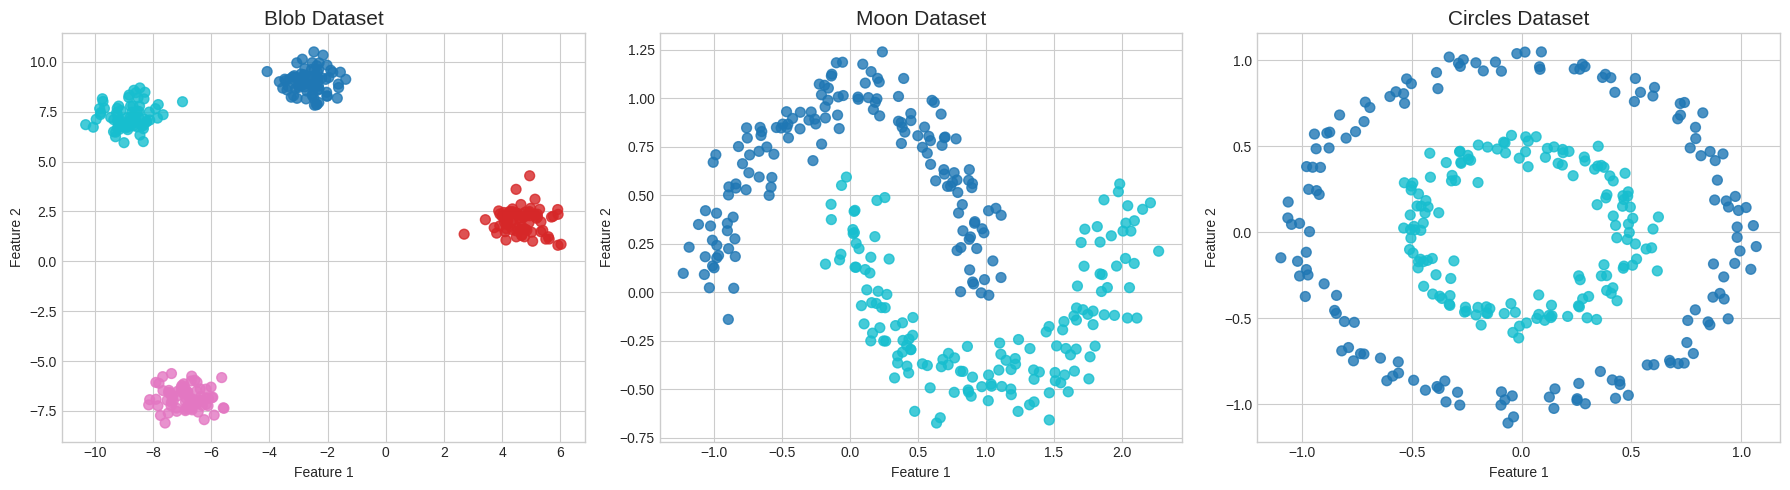

In [4]:
# Function for plotting datasets
def plot_datasets():
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs, cmap=cmap, s=50, alpha=0.8)
    axes[0].set_title('Blob Dataset', fontsize=15)

    axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=cmap, s=50, alpha=0.8)
    axes[1].set_title('Moon Dataset', fontsize=15)

    axes[2].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap=cmap, s=50, alpha=0.8)
    axes[2].set_title('Circles Dataset', fontsize=15)

    for ax in axes:
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

plot_datasets()

In [5]:
# Apply scaling to all datasets
scaler = StandardScaler()
X_blobs_scaled = scaler.fit_transform(X_blobs)
X_moons_scaled = scaler.fit_transform(X_moons)
X_circles_scaled = scaler.fit_transform(X_circles)

In [6]:
# Combine all datasets for later comparison
datasets = {
    'Blobs': (X_blobs_scaled, y_blobs, 4),
    'Moons': (X_moons_scaled, y_moons, 2),
    'Circles': (X_circles_scaled, y_circles, 2)
}

# 1. K-Means Clustering

## 1.1 Implementation from Scratch


In [7]:
class KMeansFromScratch:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
        self.history = []  # Store centroids at each iteration for animation

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize centroids - random selection from data points
        idx = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[idx, :]
        self.history.append(self.centroids.copy())

        # Initial assignment
        distances = cdist(X, self.centroids)
        self.labels_ = np.argmin(distances, axis=1)

        # Iterative optimization
        for i in range(self.max_iter):
            # Store old centroids for convergence check
            old_centroids = self.centroids.copy()

            # Update centroids based on current assignments
            for k in range(self.n_clusters):
                if np.sum(self.labels_ == k) > 0:  # Avoid empty clusters
                    self.centroids[k] = np.mean(X[self.labels_ == k], axis=0)

            # Save centroids for visualization
            self.history.append(self.centroids.copy())

            # Reassign points to closest centroids
            distances = cdist(X, self.centroids)
            new_labels = np.argmin(distances, axis=1)

            # Check for convergence (no reassignments)
            if np.sum(self.labels_ != new_labels) == 0:
                break

            # Check for convergence (centroids movement)
            if np.all(np.sqrt(np.sum((self.centroids - old_centroids) ** 2, axis=1)) < self.tol):
                break

            self.labels_ = new_labels

        # Calculate inertia (sum of squared distances to nearest centroid)
        self.inertia_ = np.sum(np.min(cdist(X, self.centroids) ** 2, axis=1))
        return self

    def predict(self, X):
        distances = cdist(X, self.centroids)
        return np.argmin(distances, axis=1)

In [8]:
# Visualize k-means iterations
def plot_kmeans_iterations(X, kmeans):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Select 6 iterations to display
    iter_to_show = [0, 1, 2, 3, 5, len(kmeans.history)-1]

    for i, iter_idx in enumerate(iter_to_show):
        if iter_idx >= len(kmeans.history):
            break

        centroids = kmeans.history[iter_idx]

        # For the final iteration, use the actual cluster assignments
        if iter_idx == len(kmeans.history) - 1:
            labels = kmeans.labels_
        else:
            # For other iterations, assign points to nearest centroids
            distances = cdist(X, centroids)
            labels = np.argmin(distances, axis=1)

        axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=50, alpha=0.8)
        axes[i].scatter(centroids[:, 0], centroids[:, 1], c=range(len(centroids)),
                       marker='*', s=200, edgecolor='k', cmap=cmap)

        title = f"Iteration {iter_idx}" if iter_idx < len(kmeans.history)-1 else "Final Result"
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

## 1.2 Testing K-Means on Datasets

In [9]:
def apply_kmeans(X, n_clusters):
    # From scratch implementation
    start_time = time.time()
    kmeans_scratch = KMeansFromScratch(n_clusters=n_clusters, max_iter=100)
    kmeans_scratch.fit(X)
    scratch_time = time.time() - start_time

    # Scikit-learn implementation
    start_time = time.time()
    kmeans_sklearn = KMeans(n_clusters=n_clusters, max_iter=100, n_init=10, random_state=42)
    kmeans_sklearn.fit(X)
    sklearn_time = time.time() - start_time

    return kmeans_scratch, kmeans_sklearn, scratch_time, sklearn_time

In [10]:
# Apply to blob dataset and visualize
kmeans_scratch, kmeans_sklearn, scratch_time, sklearn_time = apply_kmeans(X_blobs_scaled, 4)

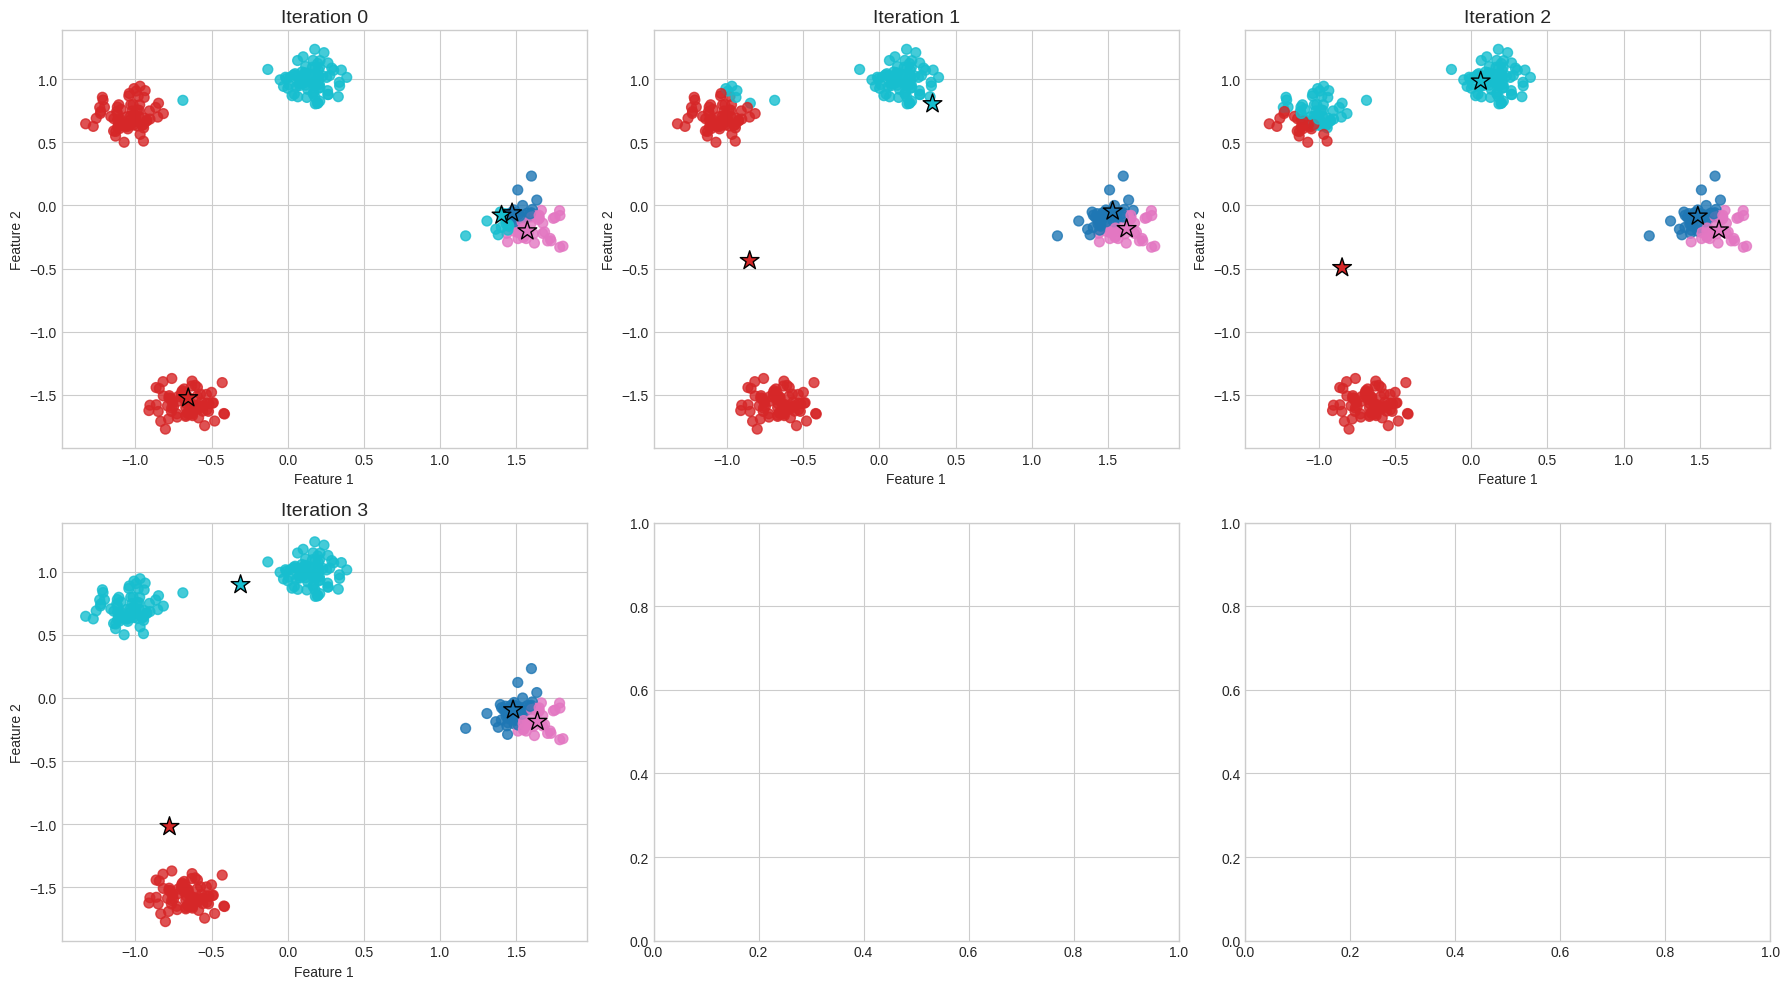

In [11]:
# Plot iterations of k-means from scratch
plot_kmeans_iterations(X_blobs_scaled, kmeans_scratch)

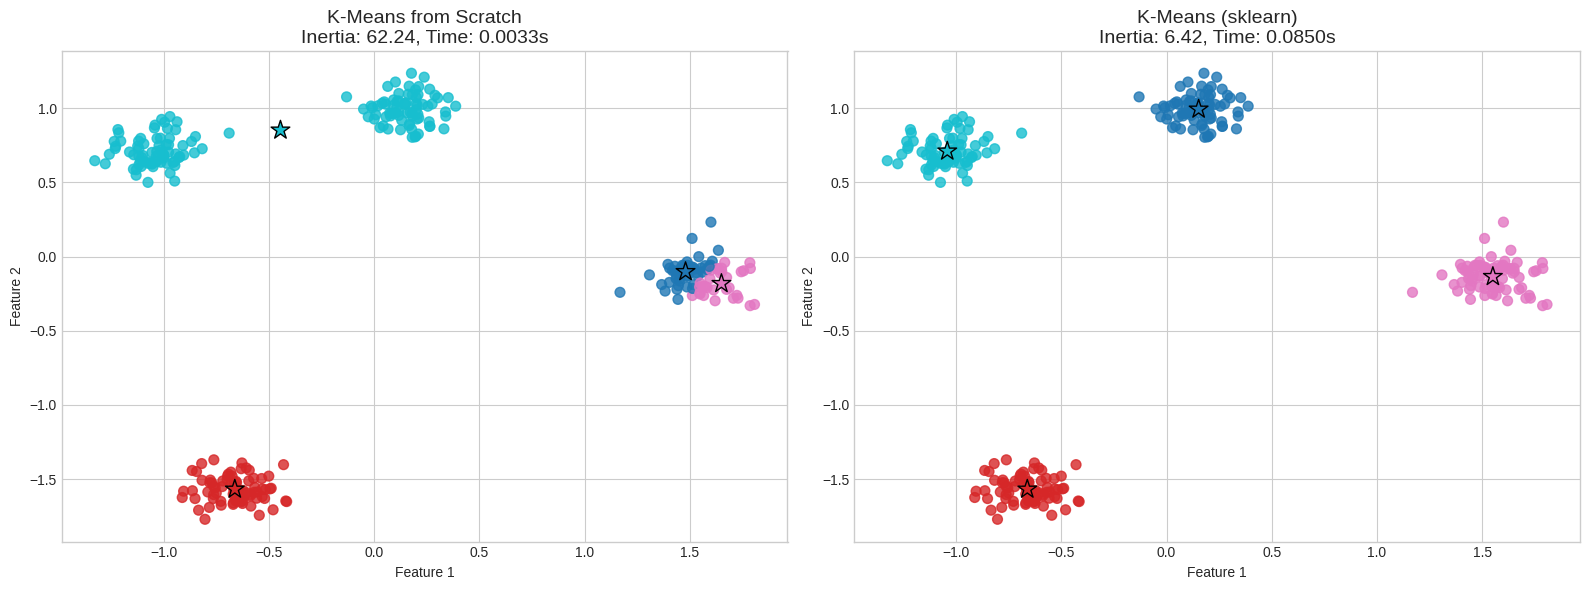

In [13]:
# Compare results between scratch and sklearn implementations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot from scratch implementation results
axes[0].scatter(X_blobs_scaled[:, 0], X_blobs_scaled[:, 1], c=kmeans_scratch.labels_, cmap=cmap, s=50, alpha=0.8)
axes[0].scatter(kmeans_scratch.centroids[:, 0], kmeans_scratch.centroids[:, 1],
               c=range(kmeans_scratch.n_clusters), marker='*', s=200, edgecolor='k', cmap=cmap)
axes[0].set_title(f'K-Means from Scratch\nInertia: {kmeans_scratch.inertia_:.2f}, Time: {scratch_time:.4f}s', fontsize=14)

# Plot sklearn implementation results
axes[1].scatter(X_blobs_scaled[:, 0], X_blobs_scaled[:, 1], c=kmeans_sklearn.labels_, cmap=cmap, s=50, alpha=0.8)
axes[1].scatter(kmeans_sklearn.cluster_centers_[:, 0], kmeans_sklearn.cluster_centers_[:, 1],
               c=range(kmeans_sklearn.n_clusters), marker='*', s=200, edgecolor='k', cmap=cmap)
axes[1].set_title(f'K-Means (sklearn)\nInertia: {kmeans_sklearn.inertia_:.2f}, Time: {sklearn_time:.4f}s', fontsize=14)

for ax in axes:
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## 1.3 Finding Optimal K (Elbow Method)

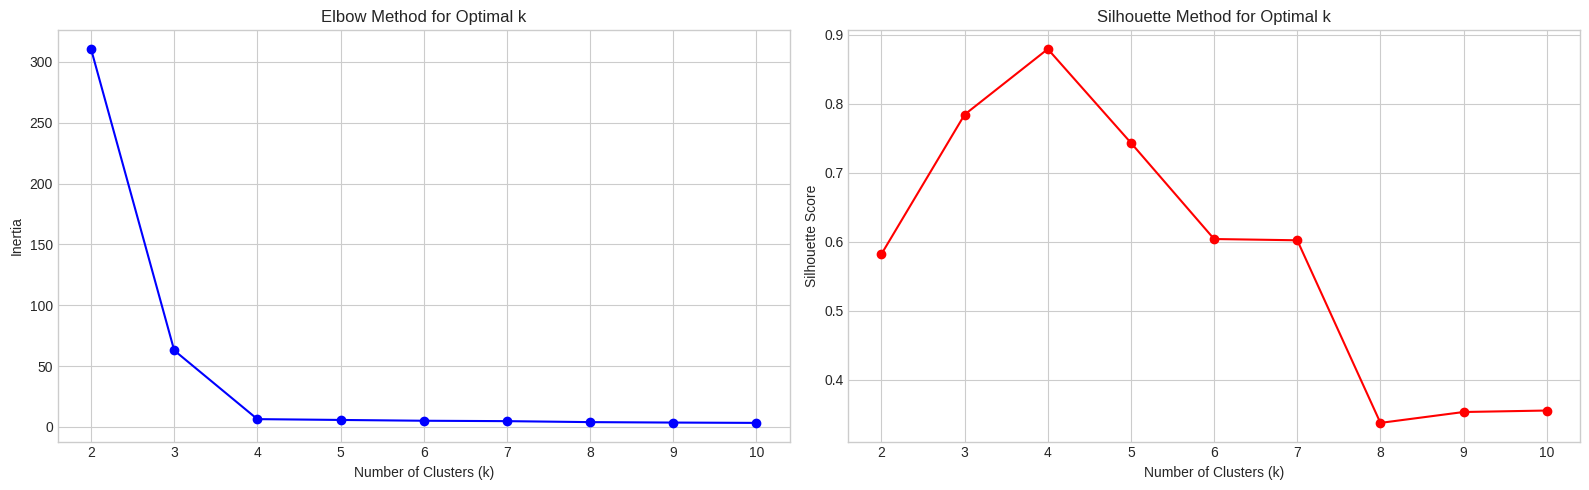

In [15]:
def elbow_method(X):
    inertia_values = []
    silhouette_values = []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertia_values.append(kmeans.inertia_)

        # Calculate silhouette score
        if k > 1:  # Silhouette score requires at least 2 clusters
            silhouette_values.append(silhouette_score(X, kmeans.labels_))

    # Plot elbow method and silhouette scores
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Elbow method
    axes[0].plot(k_range, inertia_values, 'bo-')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method for Optimal k')

    # Silhouette method
    axes[1].plot(k_range, silhouette_values, 'ro-')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Method for Optimal k')

    plt.tight_layout()
    plt.show()

# Apply elbow method to blob dataset
elbow_method(X_blobs_scaled)

# 2. Hierarchical Clustering

## 2.1 Implementation from Scratch

In [16]:
class HierarchicalClusteringFromScratch:
    def __init__(self, n_clusters=3, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None
        self.distances = None
        self.linkage_matrix = None

    def fit(self, X):
        n_samples = X.shape[0]

        # Compute pairwise distances
        self.distances = squareform(pdist(X))

        # Initialize each point as a cluster
        clusters = [[i] for i in range(n_samples)]

        # Store the merge history for dendrogram
        self.linkage_matrix = []

        # Iteratively merge clusters
        for i in range(n_samples - 1):
            # Find two closest clusters
            min_dist = np.inf
            merge_i, merge_j = 0, 0

            for i_idx, cluster_i in enumerate(clusters):
                if not cluster_i:  # Skip empty clusters
                    continue
                for j_idx, cluster_j in enumerate(clusters[i_idx+1:], i_idx+1):
                    if not cluster_j:  # Skip empty clusters
                        continue

                    # Calculate distance between clusters based on linkage method
                    if self.linkage == 'single':
                        # Single linkage: minimum distance between any points
                        cluster_dist = np.min([self.distances[i, j] for i in cluster_i for j in cluster_j])
                    elif self.linkage == 'complete':
                        # Complete linkage: maximum distance between any points
                        cluster_dist = np.max([self.distances[i, j] for i in cluster_i for j in cluster_j])
                    else:  # Default to average linkage
                        # Average linkage: average distance between all pairs
                        cluster_dist = np.mean([self.distances[i, j] for i in cluster_i for j in cluster_j])

                    if cluster_dist < min_dist:
                        min_dist = cluster_dist
                        merge_i, merge_j = i_idx, j_idx

            # Record merge for dendrogram
            cluster_size_i = len(clusters[merge_i])
            cluster_size_j = len(clusters[merge_j])

            # Store (id of first cluster, id of second cluster, distance, size of new cluster)
            self.linkage_matrix.append([merge_i, merge_j, min_dist, cluster_size_i + cluster_size_j])

            # Merge clusters
            clusters[merge_i].extend(clusters[merge_j])
            clusters[merge_j] = []  # Mark as merged

            # Check if we have reached desired number of clusters
            active_clusters = [c for c in clusters if c]
            if len(active_clusters) <= self.n_clusters:
                break

        # Assign cluster labels
        self.labels_ = np.zeros(n_samples, dtype=int)
        active_clusters = [c for c in clusters if c]

        for cluster_idx, cluster in enumerate(active_clusters):
            for sample_idx in cluster:
                self.labels_[sample_idx] = cluster_idx

        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

## 2.2 Testing Hierarchical Clustering

In [17]:
def apply_hierarchical(X, n_clusters, linkage_method='ward'):
    # From scratch implementation (using average linkage as it's simpler to implement)
    scratch_linkage = 'average' if linkage_method == 'ward' else linkage_method

    start_time = time.time()
    hier_scratch = HierarchicalClusteringFromScratch(n_clusters=n_clusters, linkage=scratch_linkage)
    hier_scratch.fit(X)
    scratch_time = time.time() - start_time

    # Scikit-learn implementation
    start_time = time.time()
    hier_sklearn = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    hier_sklearn.fit(X)
    sklearn_time = time.time() - start_time

    return hier_scratch, hier_sklearn, scratch_time, sklearn_time

In [18]:
# Apply to blob dataset
hier_scratch, hier_sklearn, scratch_time, sklearn_time = apply_hierarchical(X_blobs_scaled, 4)

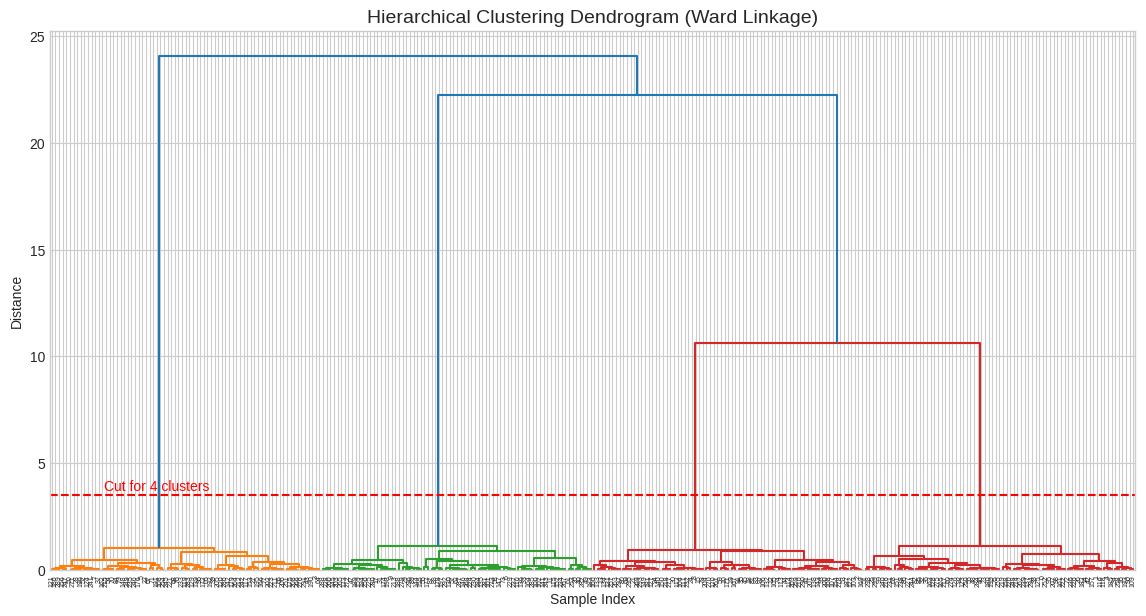

In [19]:
# Create dendrogram using scipy's linkage function
plt.figure(figsize=(14, 7))
Z = linkage(X_blobs_scaled, method='ward')
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14)
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.axhline(y=3.5, color='r', linestyle='--')  # Suggest cut for 4 clusters
plt.text(len(X_blobs_scaled) // 2, 3.7, 'Cut for 4 clusters', color='r')
plt.show()

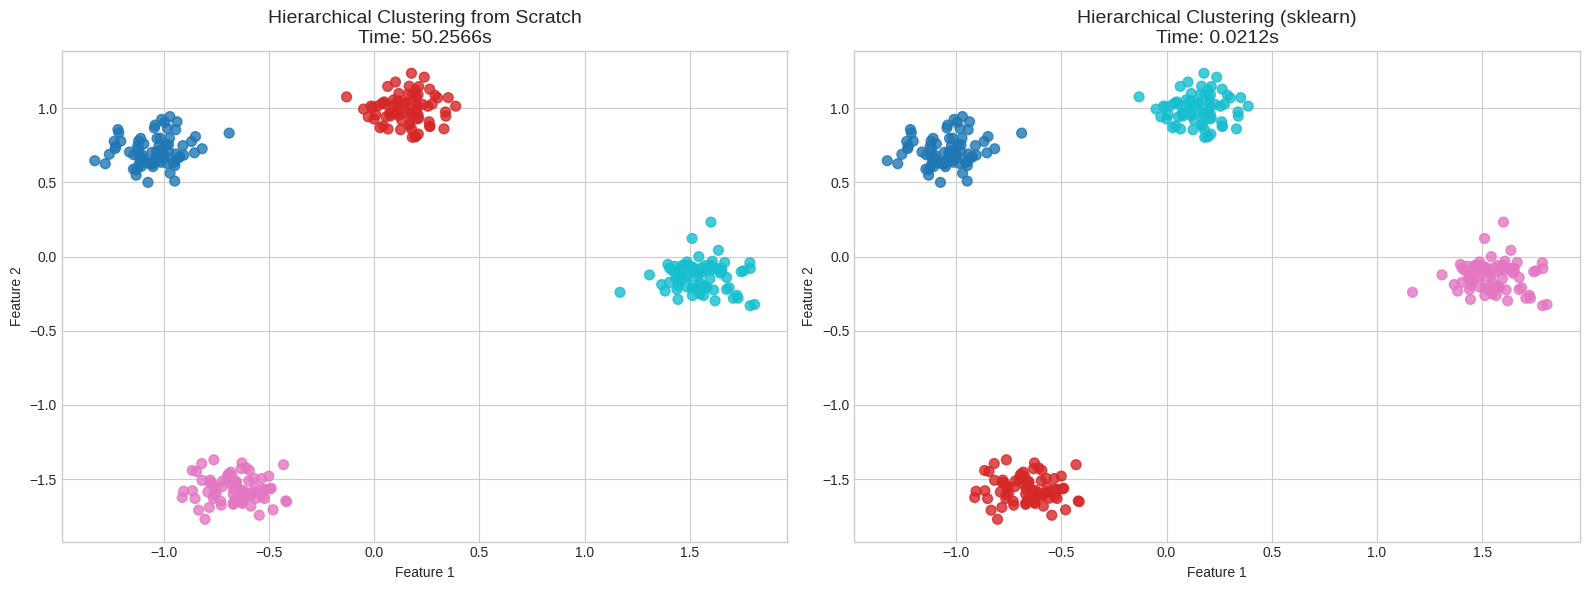

In [20]:
# Compare results between scratch and sklearn implementations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot from scratch implementation results
axes[0].scatter(X_blobs_scaled[:, 0], X_blobs_scaled[:, 1], c=hier_scratch.labels_, cmap=cmap, s=50, alpha=0.8)
axes[0].set_title(f'Hierarchical Clustering from Scratch\nTime: {scratch_time:.4f}s', fontsize=14)

# Plot sklearn implementation results
axes[1].scatter(X_blobs_scaled[:, 0], X_blobs_scaled[:, 1], c=hier_sklearn.labels_, cmap=cmap, s=50, alpha=0.8)
axes[1].set_title(f'Hierarchical Clustering (sklearn)\nTime: {sklearn_time:.4f}s', fontsize=14)

for ax in axes:
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## 2.3 Compare Different Linkage Methods

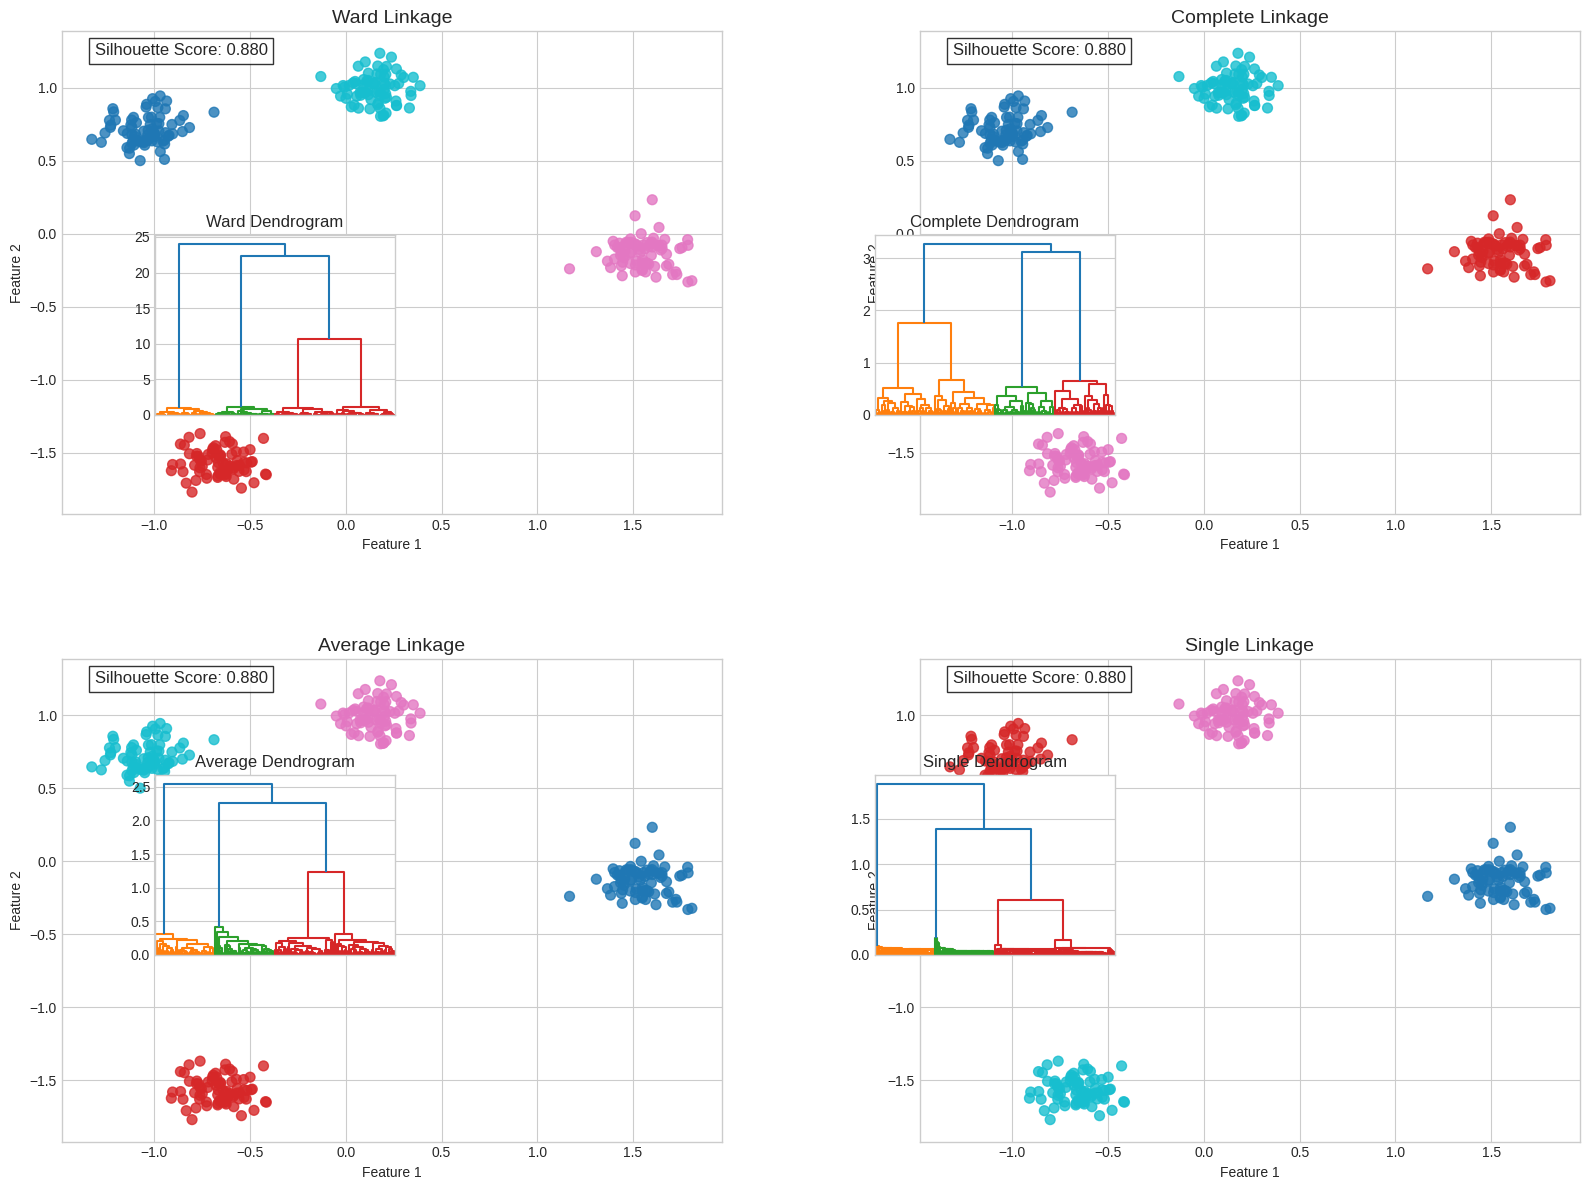

In [21]:
def compare_linkage_methods(X, n_clusters=4):
    linkage_methods = ['ward', 'complete', 'average', 'single']
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, method in enumerate(linkage_methods):
        # Create dendrogram
        Z = linkage(X, method=method)
        ax_inset = fig.add_axes([0.1 + (i%2)*0.45, 0.65 - (i//2)*0.45, 0.15, 0.15])
        dendrogram(Z, ax=ax_inset, no_labels=True)
        ax_inset.set_title(f'{method.capitalize()} Dendrogram')

        # Apply clustering
        hier = AgglomerativeClustering(n_clusters=n_clusters, linkage=method)
        labels = hier.fit_predict(X)

        # Plot clusters
        axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=50, alpha=0.8)
        axes[i].set_title(f'{method.capitalize()} Linkage', fontsize=14)
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')

        # Calculate silhouette score
        sil_score = silhouette_score(X, labels)
        axes[i].text(0.05, 0.95, f'Silhouette Score: {sil_score:.3f}',
                   transform=axes[i].transAxes, fontsize=12,
                   bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
# Compare linkage methods on blob dataset
compare_linkage_methods(X_blobs_scaled)

# 3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

## 3.1 Implementation from Scratch

In [22]:
class DBSCANFromScratch:
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.core_sample_indices_ = None

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.full(n_samples, -1)  # Initialize all as noise

        # Calculate distance matrix
        distances = squareform(pdist(X))

        # Find all neighbors for each point
        neighbors = [np.where(distances[i] <= self.eps)[0] for i in range(n_samples)]

        # Identify core points
        core_points = np.array([i for i, n in enumerate(neighbors)
                                if len(n) >= self.min_samples])
        self.core_sample_indices_ = core_points

        # Initialize with first core point
        if len(core_points) == 0:
            return self  # No core points found

        # Assign initial cluster labels to core points
        cluster_id = 0
        for point_idx in range(n_samples):
            # Skip if already classified or not a core point
            if self.labels_[point_idx] != -1 or point_idx not in core_points:
                continue

            # Assign new cluster ID to this core point
            self.labels_[point_idx] = cluster_id

            # Start BFS from this core point
            queue = [point_idx]
            while queue:
                current = queue.pop(0)

                # Get all neighbors that are unclassified
                for neighbor in neighbors[current]:
                    if self.labels_[neighbor] == -1:  # Unclassified point
                        self.labels_[neighbor] = cluster_id

                        # If this neighbor is also a core point, add to queue
                        if neighbor in core_points:
                            queue.append(neighbor)

            # Increment cluster ID for next cluster
            cluster_id += 1

        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

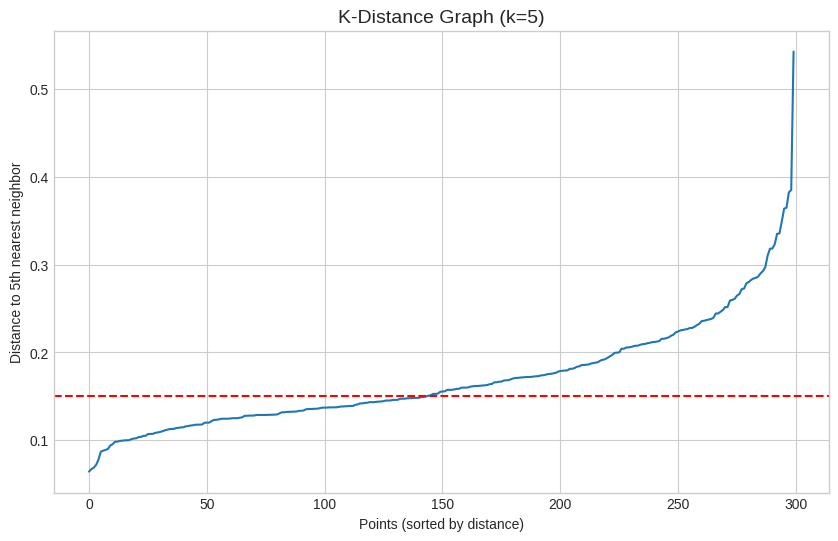

Look for the 'elbow' in the k-distance graph to determine a good eps value.
Points above this value will likely be classified as noise.


In [24]:
# Function to find optimal DBSCAN parameters
def find_optimal_dbscan_params(X):
    # Calculate distances to k nearest neighbors
    k = 5  # We'll look at the distance to the 5th nearest neighbor
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, _ = nbrs.kneighbors(X)

    # Sort the distances to the kth neighbor
    k_dist = np.sort(distances[:, k-1])

    # Plot k-distance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(X)), k_dist)
    plt.axhline(y=0.15, color='r', linestyle='--')  # Example threshold
    plt.title(f'K-Distance Graph (k={k})', fontsize=14)
    plt.xlabel('Points (sorted by distance)')
    plt.ylabel(f'Distance to {k}th nearest neighbor')
    plt.grid(True)
    plt.show()

    print("Look for the 'elbow' in the k-distance graph to determine a good eps value.")
    print("Points above this value will likely be classified as noise.")

find_optimal_dbscan_params(X_moons_scaled)

## 3.2 Testing DBSCAN

In [25]:
def apply_dbscan(X, eps=0.5, min_samples=5):
    # From scratch implementation
    start_time = time.time()
    dbscan_scratch = DBSCANFromScratch(eps=eps, min_samples=min_samples)
    dbscan_scratch.fit(X)
    scratch_time = time.time() - start_time

    # Scikit-learn implementation
    start_time = time.time()
    dbscan_sklearn = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_sklearn.fit(X)
    sklearn_time = time.time() - start_time

    return dbscan_scratch, dbscan_sklearn, scratch_time, sklearn_time

In [26]:
# Apply DBSCAN to moons dataset (better suited than blobs)
dbscan_scratch, dbscan_sklearn, scratch_time, sklearn_time = apply_dbscan(X_moons_scaled, eps=0.3, min_samples=5)

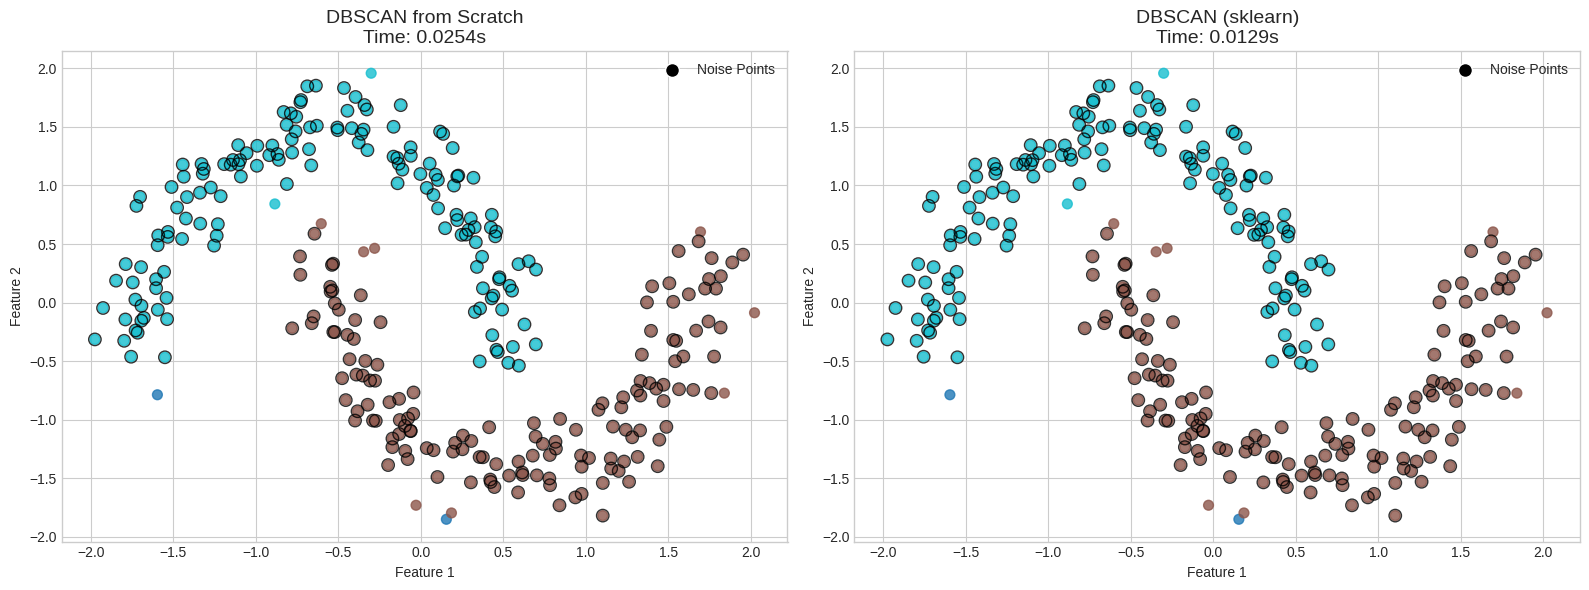

In [27]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot from scratch implementation results
scatter_scratch = axes[0].scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1],
                              c=dbscan_scratch.labels_, cmap=cmap, s=50, alpha=0.8)
axes[0].set_title(f'DBSCAN from Scratch\nTime: {scratch_time:.4f}s', fontsize=14)

# Plot sklearn implementation results
scatter_sklearn = axes[1].scatter(X_moons_scaled[:, 0], X_moons_scaled[:, 1],
                              c=dbscan_sklearn.labels_, cmap=cmap, s=50, alpha=0.8)
axes[1].set_title(f'DBSCAN (sklearn)\nTime: {sklearn_time:.4f}s', fontsize=14)

# Highlight core samples
core_mask = np.zeros_like(dbscan_scratch.labels_, dtype=bool)
core_mask[dbscan_scratch.core_sample_indices_] = True

axes[0].scatter(X_moons_scaled[core_mask, 0], X_moons_scaled[core_mask, 1],
               s=80, facecolors='none', edgecolors='k', alpha=0.8)

core_mask_sklearn = np.zeros_like(dbscan_sklearn.labels_, dtype=bool)
core_mask_sklearn[dbscan_sklearn.core_sample_indices_] = True

axes[1].scatter(X_moons_scaled[core_mask_sklearn, 0], X_moons_scaled[core_mask_sklearn, 1],
               s=80, facecolors='none', edgecolors='k', alpha=0.8)

for ax in axes:
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Add annotations for noise points
for ax in axes:
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k',
                                 markersize=10, label='Noise Points')]
    ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## 3.3 Compare Different Epsilon and MinPts Values

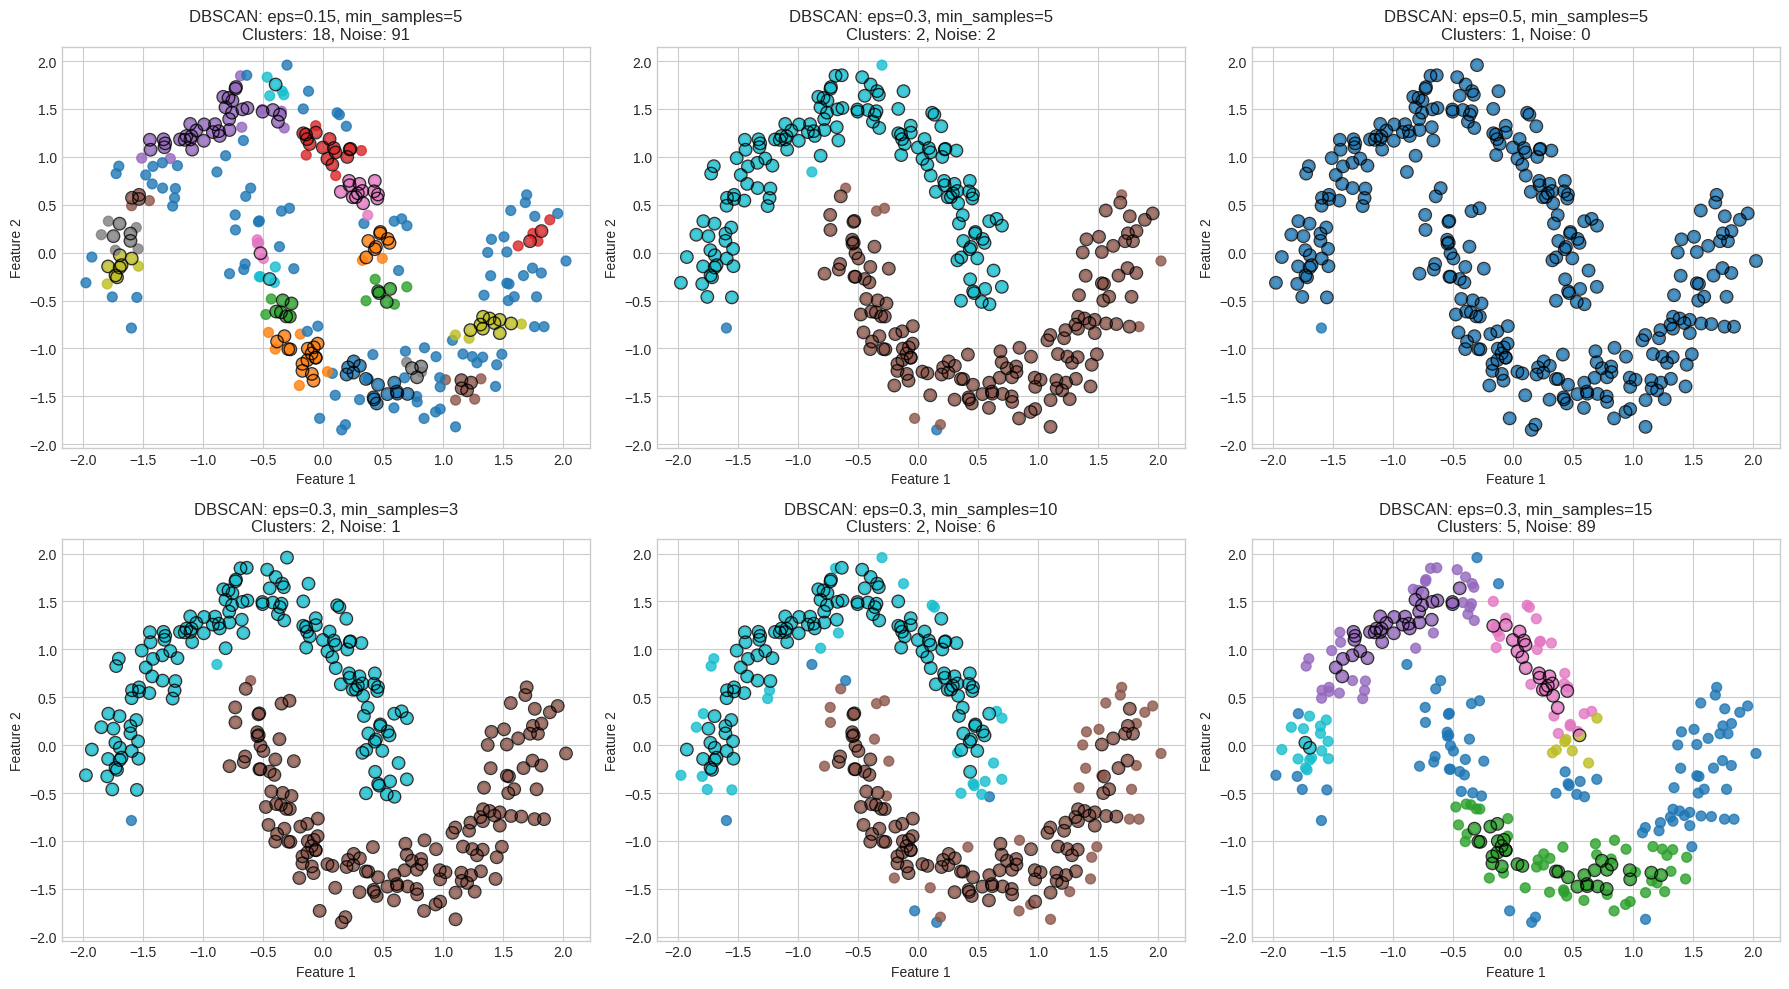

In [28]:
def compare_dbscan_params(X):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Different combinations of eps and min_samples
    params = [
        (0.15, 5), (0.3, 5), (0.5, 5),
        (0.3, 3), (0.3, 10), (0.3, 15)
    ]

    for i, (eps, min_samples) in enumerate(params):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        scatter = axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=50, alpha=0.8)

        # Highlight core samples
        core_mask = np.zeros_like(labels, dtype=bool)
        core_mask[dbscan.core_sample_indices_] = True

        axes[i].scatter(X[core_mask, 0], X[core_mask, 1],
                       s=80, facecolors='none', edgecolors='k', alpha=0.8)

        # Count number of clusters and noise points
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        axes[i].set_title(f'DBSCAN: eps={eps}, min_samples={min_samples}\n'
                         f'Clusters: {n_clusters}, Noise: {n_noise}', fontsize=12)
        axes[i].set_xlabel('Feature 1')
        axes[i].set_ylabel('Feature 2')

    plt.tight_layout()
    plt.show()

compare_dbscan_params(X_moons_scaled)

# 4. Comparison of All Clustering Methods

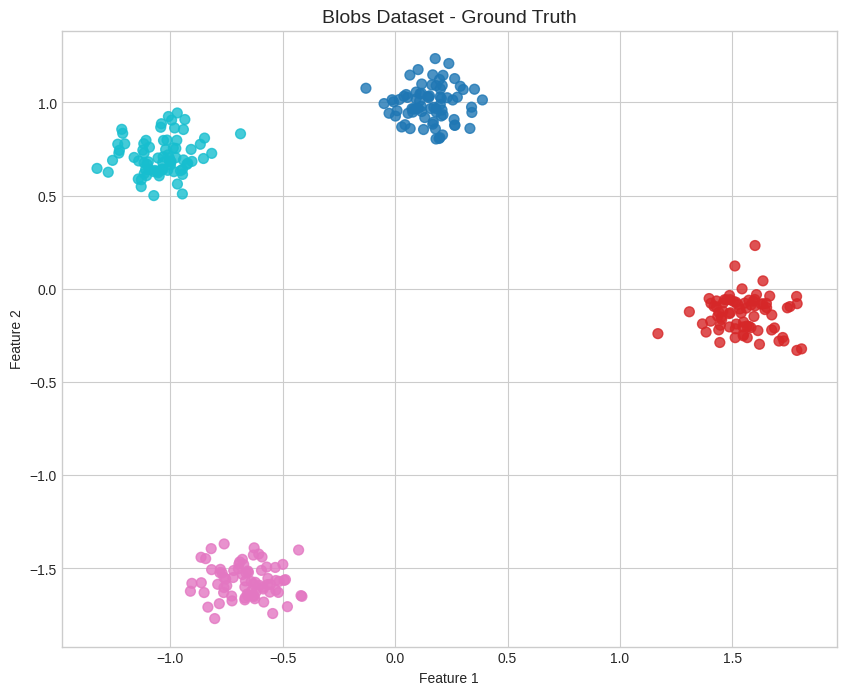

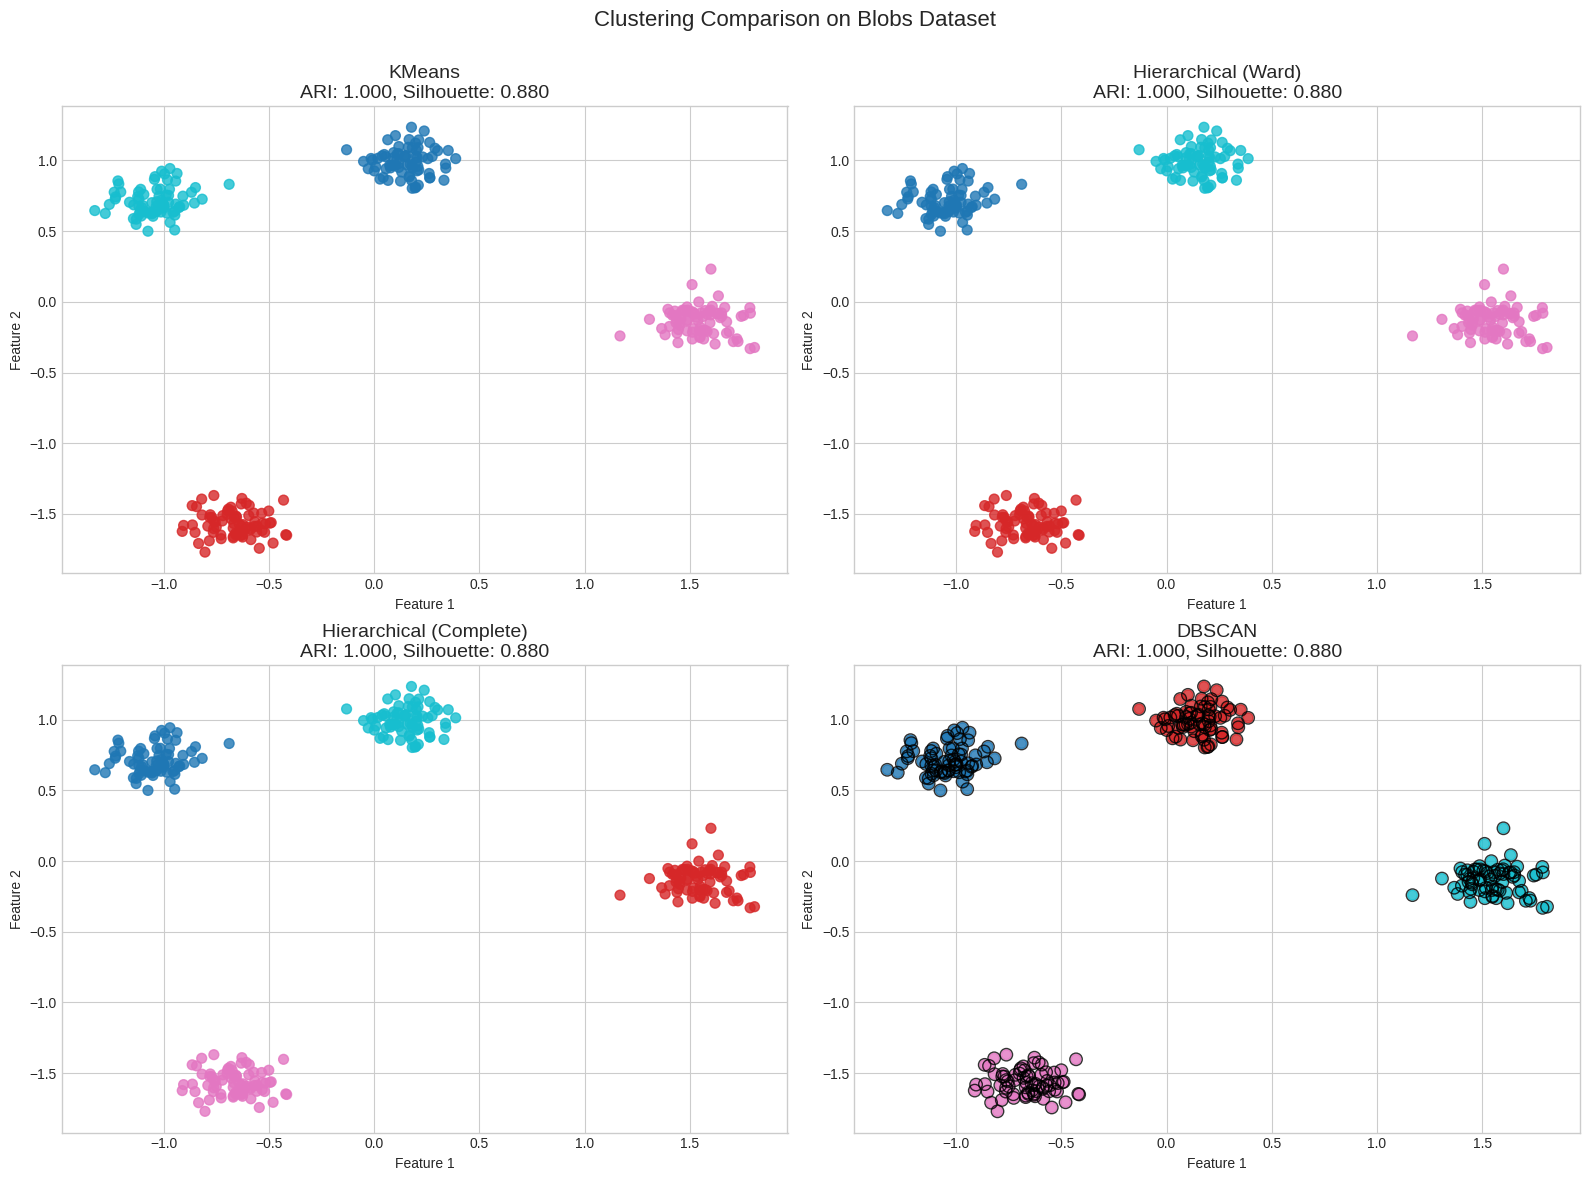

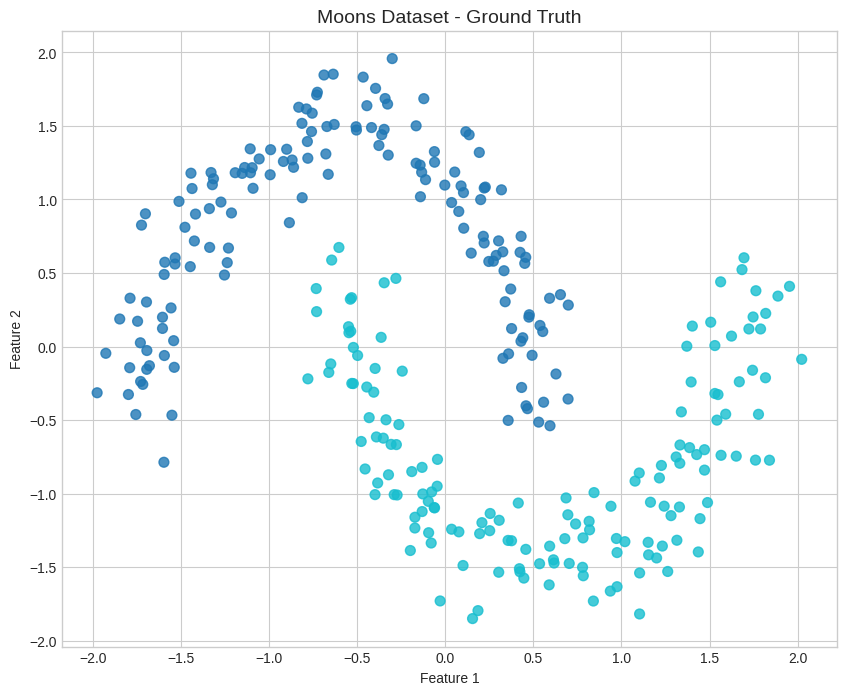

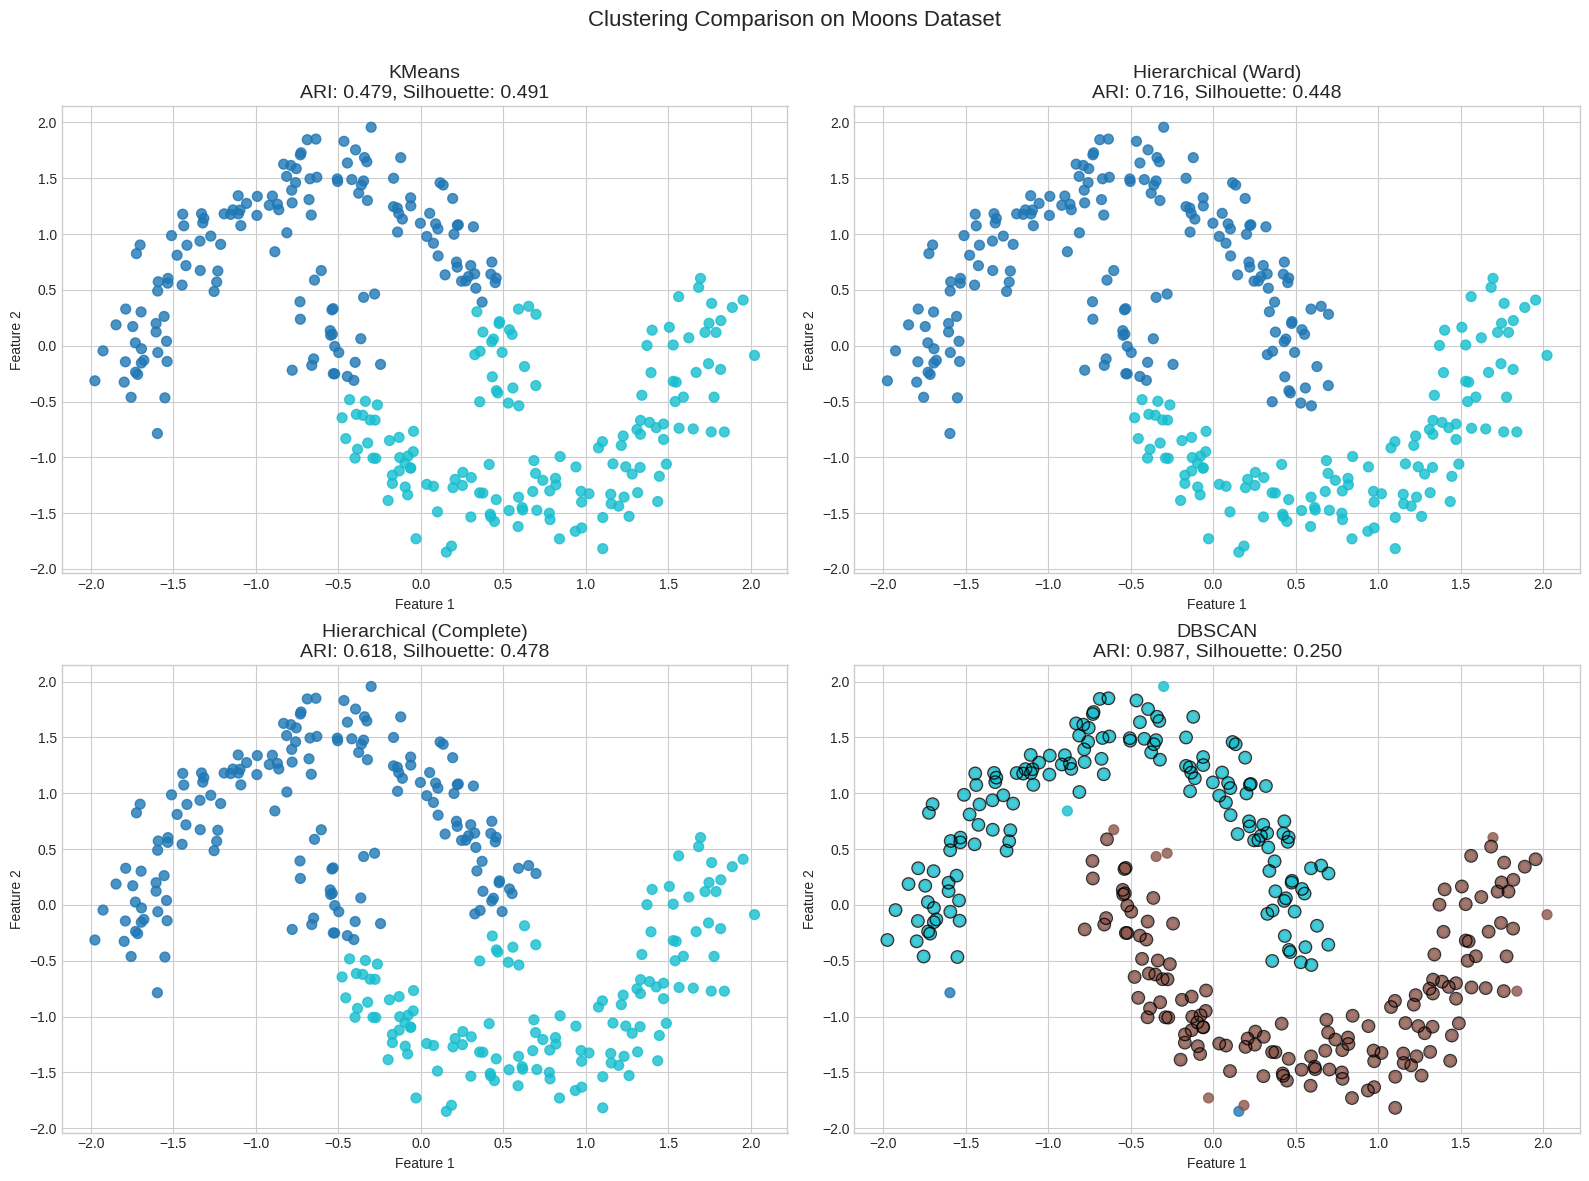

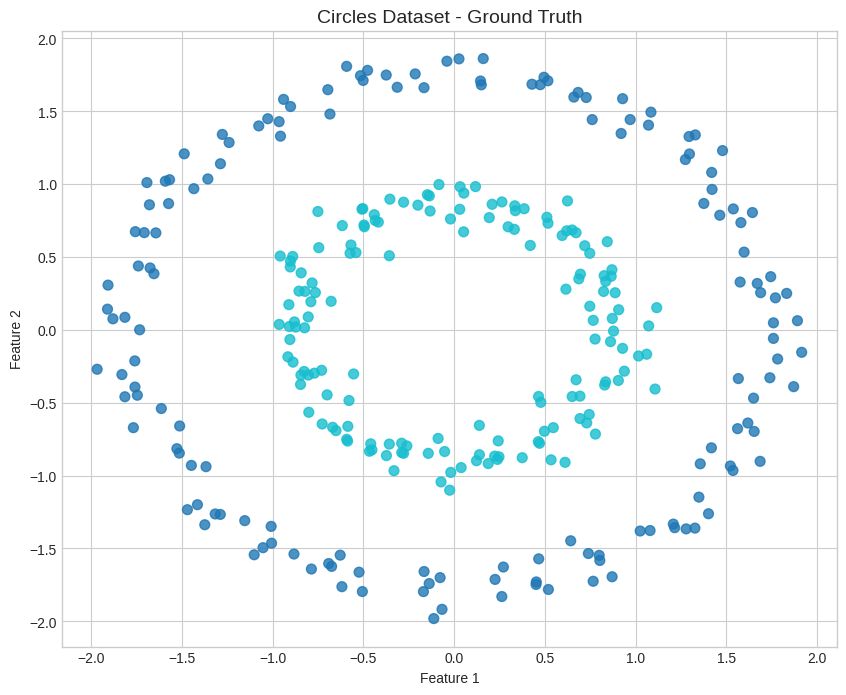

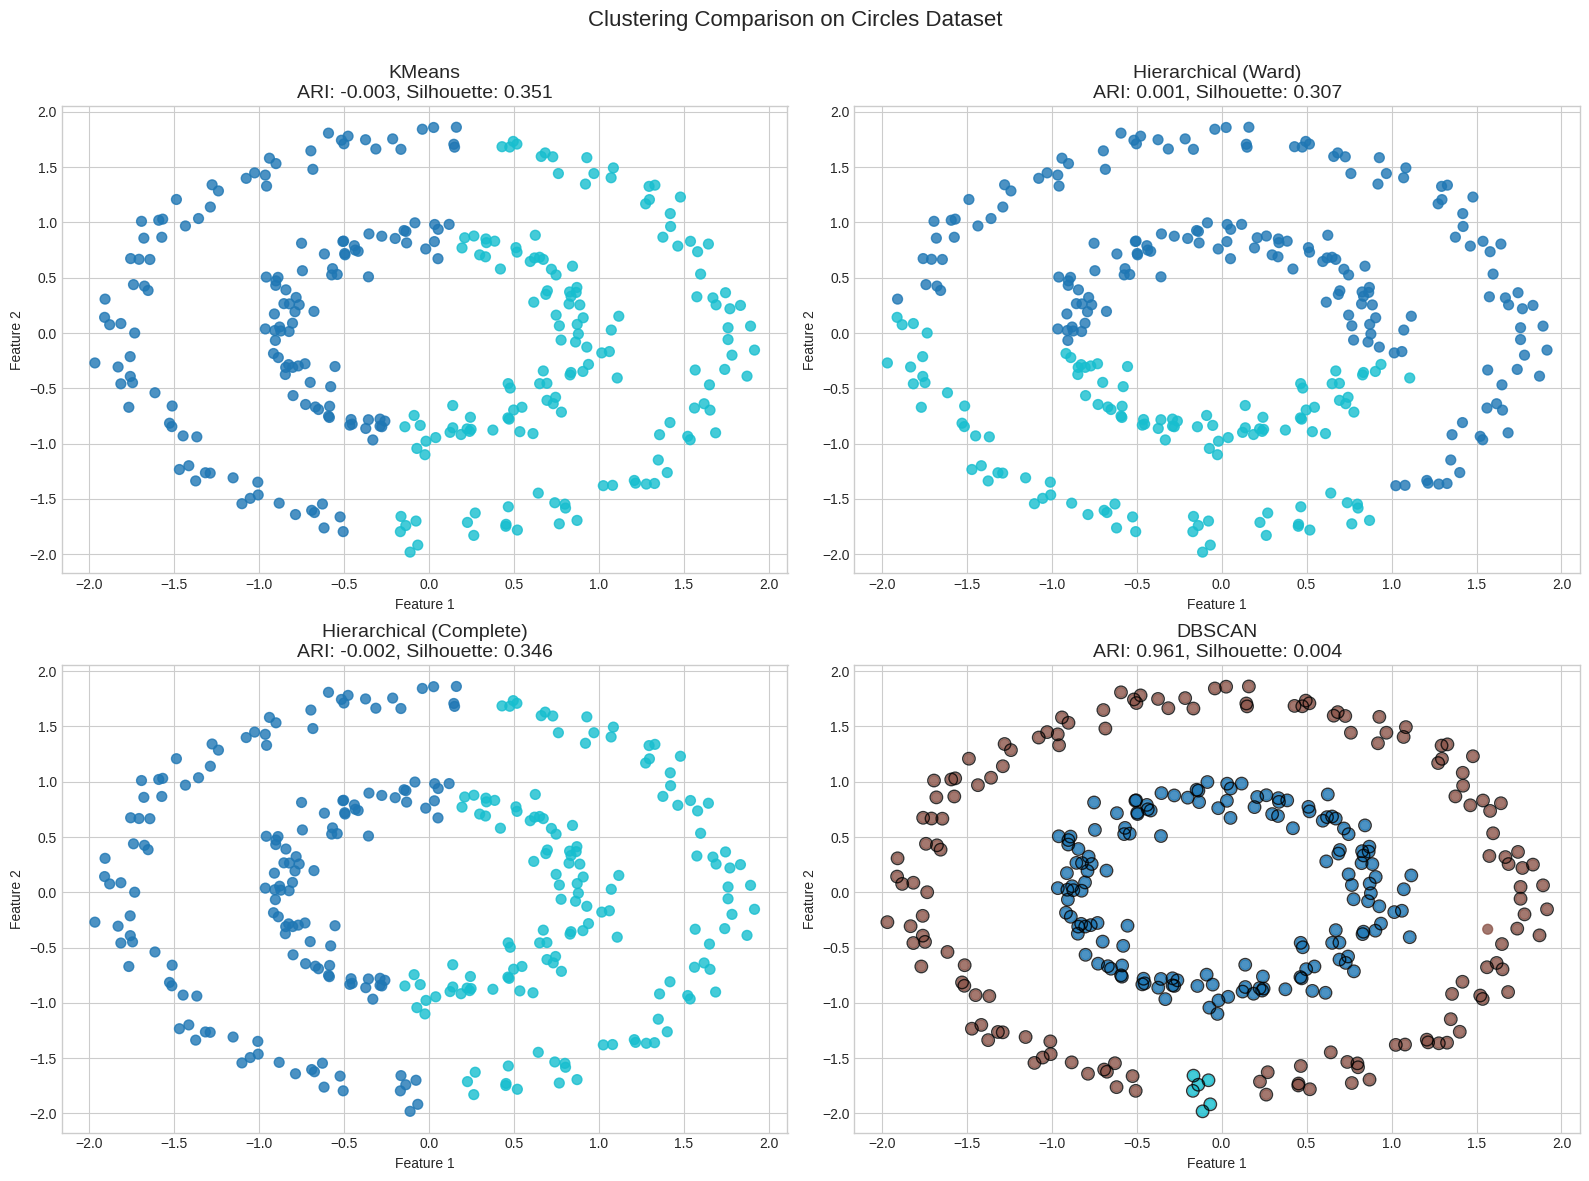

                                      ARI  Runtime (s)  Silhouette  n_clusters
Dataset Algorithm                                                             
Blobs   DBSCAN                   1.000000     0.004461    0.879591         4.0
        Hierarchical (Complete)  1.000000     0.004202    0.879591         4.0
        Hierarchical (Ward)      1.000000     0.004885    0.879591         4.0
        KMeans                   1.000000     0.004351    0.879591         4.0
Circles DBSCAN                   0.961466     0.002572    0.004177         3.0
        Hierarchical (Complete) -0.001748     0.002579    0.346459         2.0
        Hierarchical (Ward)      0.001256     0.002783    0.307348         2.0
        KMeans                  -0.003355     0.003373    0.350584         2.0
Moons   DBSCAN                   0.986666     0.005315    0.250332         2.0
        Hierarchical (Complete)  0.617577     0.004027    0.477895         2.0
        Hierarchical (Ward)      0.715917     0.0050

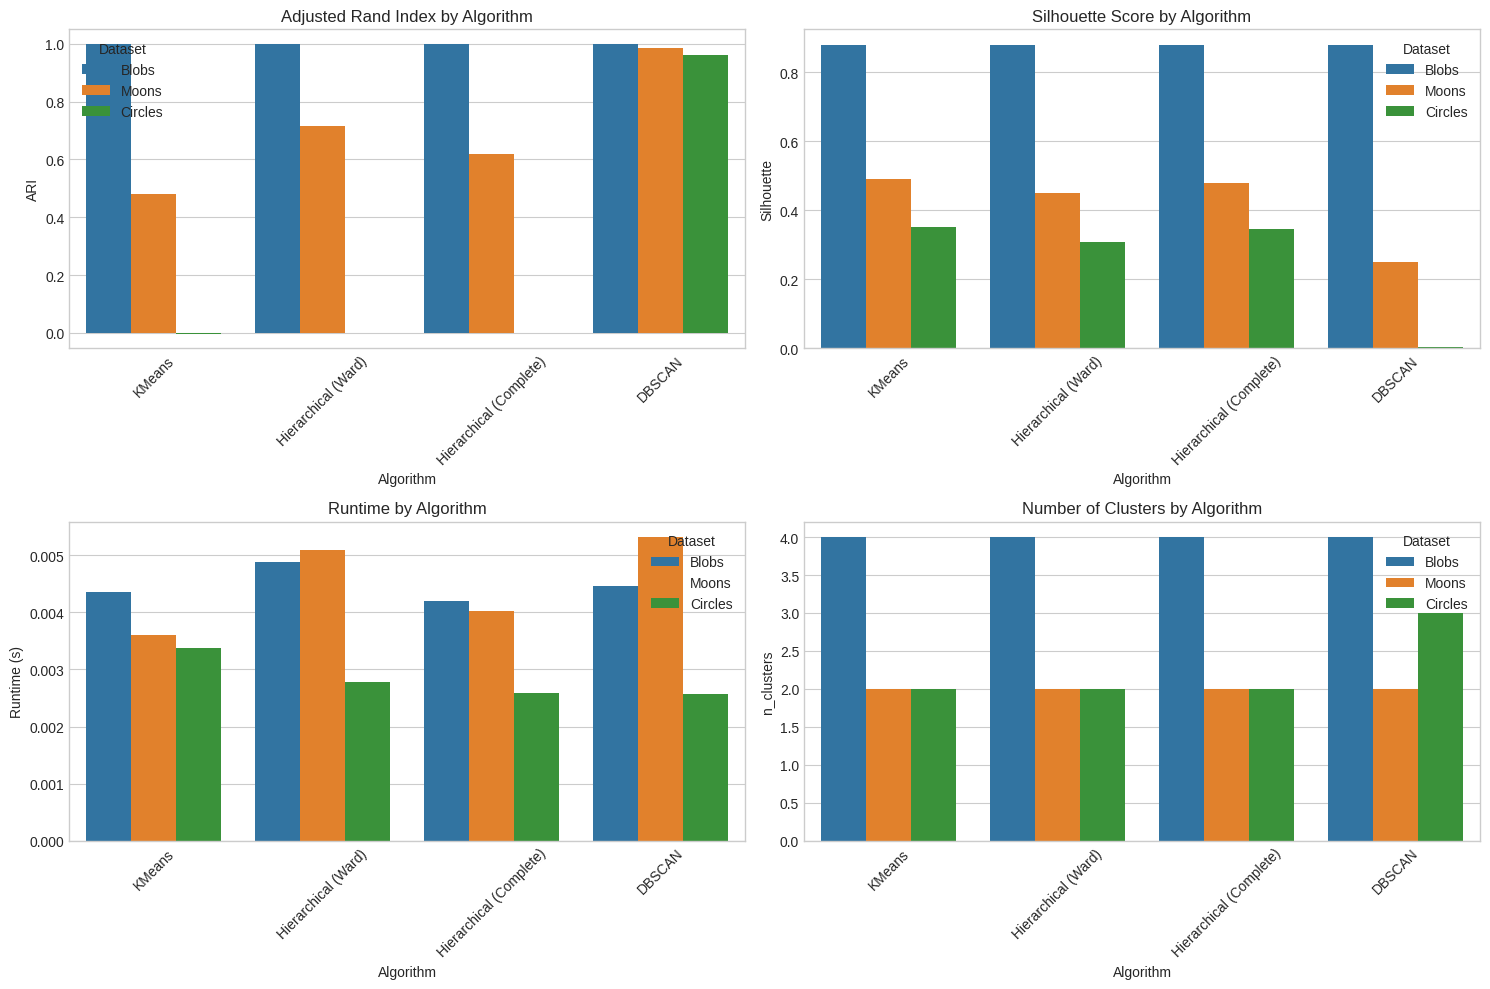

In [29]:
def compare_all_methods(datasets):
    metrics = []

    # Define algorithms with their parameters for each dataset
    algorithms = {
        'KMeans': lambda n: KMeans(n_clusters=n, random_state=42),
        'Hierarchical (Ward)': lambda n: AgglomerativeClustering(n_clusters=n, linkage='ward'),
        'Hierarchical (Complete)': lambda n: AgglomerativeClustering(n_clusters=n, linkage='complete'),
        'DBSCAN': lambda _: DBSCAN(eps=0.3, min_samples=5)  # DBSCAN doesn't use n_clusters
    }

    for dataset_name, (X, y_true, n_clusters) in datasets.items():
        # Plot ground truth
        plt.figure(figsize=(10, 8))
        plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap=cmap, s=50, alpha=0.8)
        plt.title(f'{dataset_name} Dataset - Ground Truth', fontsize=14)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        for i, (algo_name, algo_func) in enumerate(algorithms.items()):
            # Apply algorithm
            start_time = time.time()
            algo = algo_func(n_clusters)
            algo.fit(X)
            runtime = time.time() - start_time

            # Get labels
            labels = algo.labels_

            # Calculate metrics
            ari = adjusted_rand_score(y_true, labels)

            # Calculate silhouette score if more than one cluster
            unique_labels = np.unique(labels)
            if len(unique_labels) > 1 and len(unique_labels) < len(X):
                sil = silhouette_score(X, labels)
            else:
                sil = float('nan')

            # Store metrics
            metrics.append({
                'Dataset': dataset_name,
                'Algorithm': algo_name,
                'ARI': ari,
                'Silhouette': sil,
                'Runtime (s)': runtime,
                'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
            })

            # Plot clusters
            scatter = axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=50, alpha=0.8)

            # Special handling for DBSCAN to show core samples
            if algo_name == 'DBSCAN':
                core_mask = np.zeros_like(labels, dtype=bool)
                core_mask[algo.core_sample_indices_] = True
                axes[i].scatter(X[core_mask, 0], X[core_mask, 1],
                               s=80, facecolors='none', edgecolors='k', alpha=0.8)

            axes[i].set_title(f'{algo_name}\nARI: {ari:.3f}, Silhouette: {sil:.3f}', fontsize=14)
            axes[i].set_xlabel('Feature 1')
            axes[i].set_ylabel('Feature 2')

        plt.suptitle(f'Clustering Comparison on {dataset_name} Dataset', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

        # Create metrics dataframe
    metrics_df = pd.DataFrame(metrics)
    print(metrics_df.pivot_table(index=['Dataset', 'Algorithm'],
                                values=['ARI', 'Silhouette', 'Runtime (s)', 'n_clusters']))

    # Visualize metrics
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.barplot(x='Algorithm', y='ARI', hue='Dataset', data=metrics_df)
    plt.title('Adjusted Rand Index by Algorithm')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    sns.barplot(x='Algorithm', y='Silhouette', hue='Dataset', data=metrics_df)
    plt.title('Silhouette Score by Algorithm')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    sns.barplot(x='Algorithm', y='Runtime (s)', hue='Dataset', data=metrics_df)
    plt.title('Runtime by Algorithm')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 4)
    sns.barplot(x='Algorithm', y='n_clusters', hue='Dataset', data=metrics_df)
    plt.title('Number of Clusters by Algorithm')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

compare_all_methods(datasets)

# 5. Summary and Interpretation

In [30]:
# Create a comparison table
comparison_data = {
    'Algorithm': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Shape Constraints': ['Spherical clusters only', 'Can handle various shapes with certain linkages', 'Can handle arbitrary shapes'],
    'Scalability': ['Good (O(n*k*i*d))', 'Poor (O(n²*d) to O(n³*d))', 'Good for low dimensions (O(n²))'],
    'Sensitivity to Outliers': ['High', 'Depends on linkage', 'Low (identifies as noise)'],
    'Need to Specify K': ['Yes', 'Yes', 'No (needs eps and min_samples)'],
    'Deterministic': ['No (depends on initialization)', 'Yes', 'Yes'],
    'Best-suited Data': ['Well-separated spherical clusters', 'Hierarchical relationships, various shapes', 'Density-varying clusters, irregular shapes'],
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Algorithm')
display(comparison_df)

Shape Constraints  \
Algorithm                                                       
K-Means                               Spherical clusters only   
Hierarchical  Can handle various shapes with certain linkages   
DBSCAN                            Can handle arbitrary shapes   

                                  Scalability    Sensitivity to Outliers  \
Algorithm                                                                  
K-Means                     Good (O(n*k*i*d))                       High   
Hierarchical        Poor (O(n²*d) to O(n³*d))         Depends on linkage   
DBSCAN        Good for low dimensions (O(n²))  Low (identifies as noise)   

                           Need to Specify K                   Deterministic  \
Algorithm                                                                      
K-Means                                  Yes  No (depends on initialization)   
Hierarchical                             Yes                             Yes   
DBSCAN        No (needs eps and min_samples)                             Yes   

                                        Best-suited Data  
Algorithm                                                 
K-Means                Well-separated spherical clusters  
Hierarchical  Hierarchical relationships, various shapes  
DBSCAN        Density-varying clusters, irregular shapes

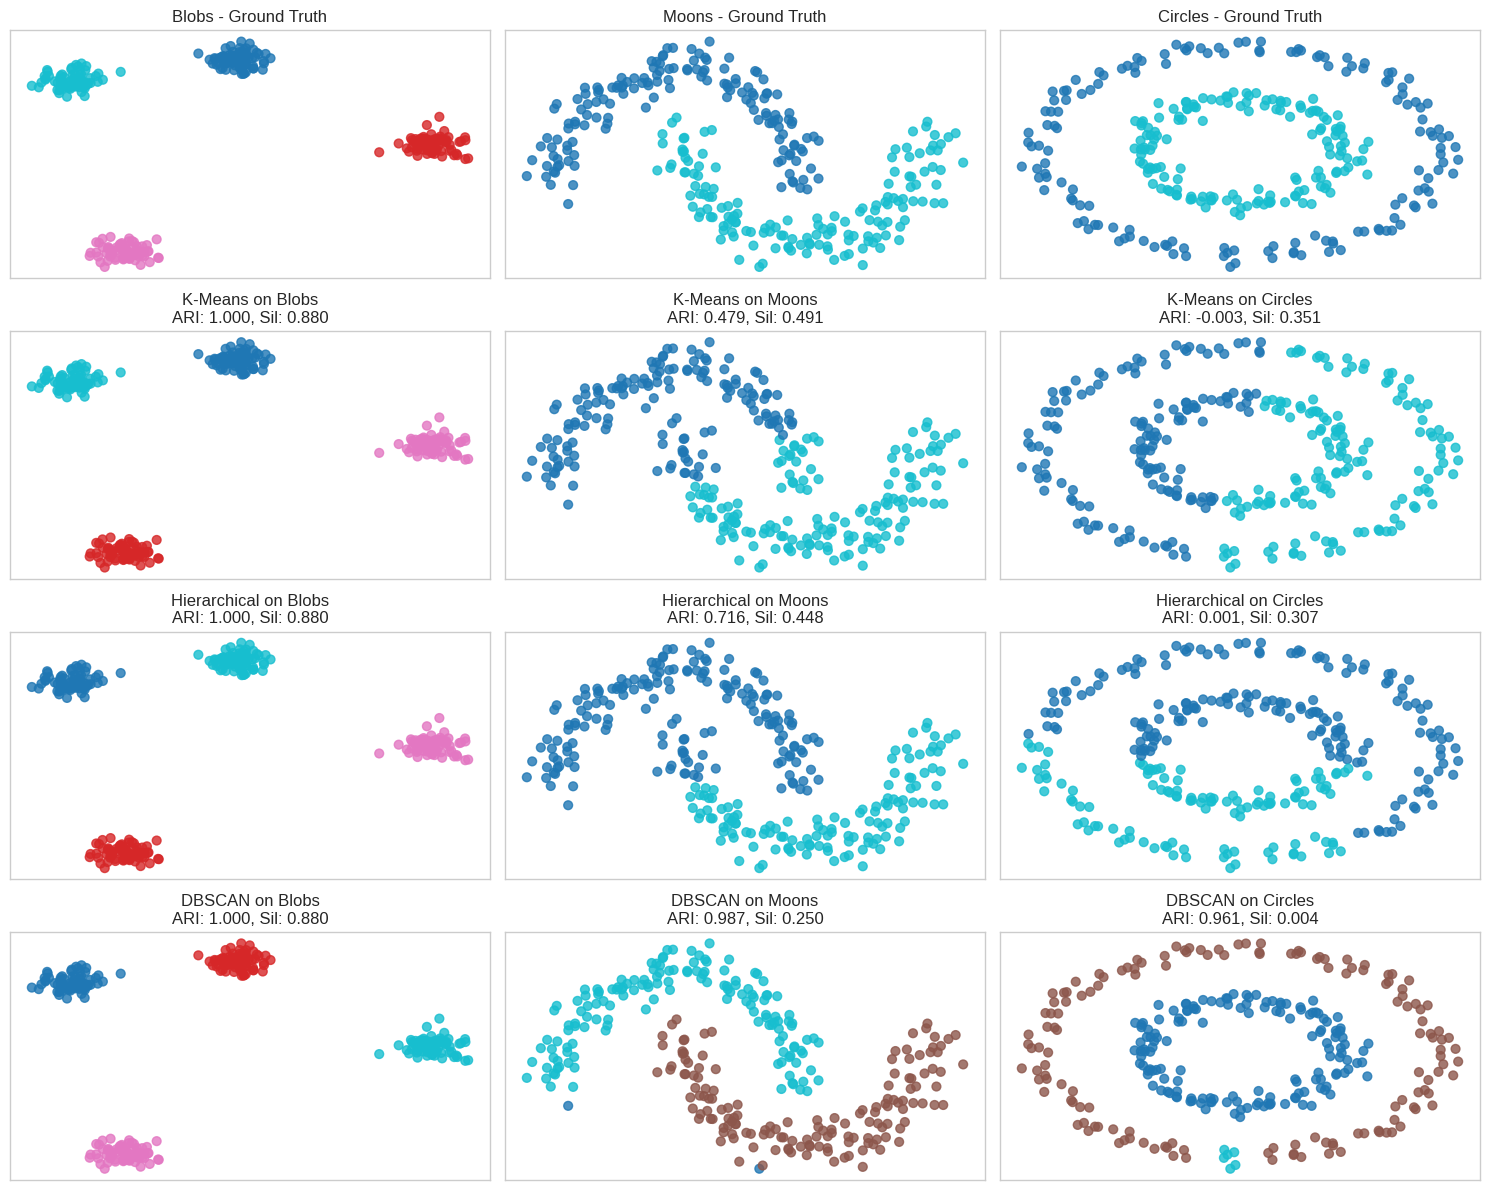

In [31]:
# Create a visual summary of algorithms' performance on different dataset shapes
plt.figure(figsize=(15, 12))

datasets_summary = [
    ('Blobs', X_blobs_scaled, 4),
    ('Moons', X_moons_scaled, 2),
    ('Circles', X_circles_scaled, 2)
]

algorithms_summary = [
    ('K-Means', lambda X, n: KMeans(n_clusters=n, random_state=42).fit(X).labels_),
    ('Hierarchical', lambda X, n: AgglomerativeClustering(n_clusters=n, linkage='ward').fit(X).labels_),
    ('DBSCAN', lambda X, _: DBSCAN(eps=0.3, min_samples=5).fit(X).labels_)
]

for i, (dataset_name, X, n_clusters) in enumerate(datasets_summary):
    # Create ground truth subplot
    plt.subplot(4, 3, i+1)
    plt.scatter(X[:, 0], X[:, 1], c=datasets[dataset_name][1], cmap=cmap, s=40, alpha=0.8)
    plt.title(f'{dataset_name} - Ground Truth')
    plt.xticks([])
    plt.yticks([])

    for j, (algo_name, algo_func) in enumerate(algorithms_summary):
        plt.subplot(4, 3, (j+1)*3 + i+1)
        labels = algo_func(X, n_clusters)
        plt.scatter(X[:, 0], X[:, 1], c=labels, cmap=cmap, s=40, alpha=0.8)

        # Calculate metrics
        ari = adjusted_rand_score(datasets[dataset_name][1], labels)

        # Calculate silhouette score if more than one cluster
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and len(unique_labels) < len(X):
            sil = silhouette_score(X, labels)
        else:
            sil = float('nan')

        plt.title(f'{algo_name} on {dataset_name}\nARI: {ari:.3f}, Sil: {sil:.3f}')
        plt.xticks([])
        plt.yticks([])

plt.tight_layout()
plt.show()

# 6. Real-World Application Example

In [39]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

In [33]:
# Load Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

In [34]:
# Standardize features
X_iris_scaled = StandardScaler().fit_transform(X_iris)

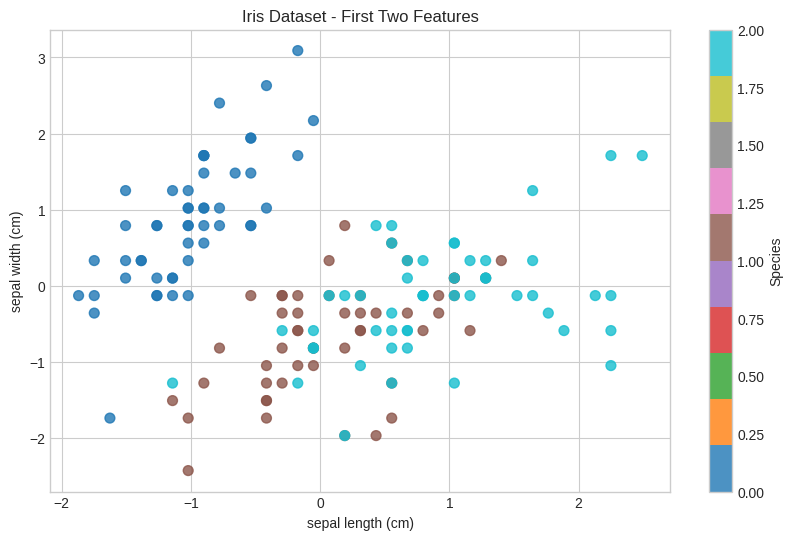

In [35]:
# Visualize the first two features (sepal length and width)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_iris_scaled[:, 0], X_iris_scaled[:, 1], c=y_iris, cmap=cmap, s=50, alpha=0.8)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title('Iris Dataset - First Two Features')
plt.colorbar(scatter, label='Species')
plt.show()

In [36]:
# Apply clustering algorithms
algorithms = {
    'K-Means': KMeans(n_clusters=3, random_state=42),
    'Hierarchical': AgglomerativeClustering(n_clusters=3, linkage='ward'),
    'DBSCAN': DBSCAN(eps=0.6, min_samples=5)
}

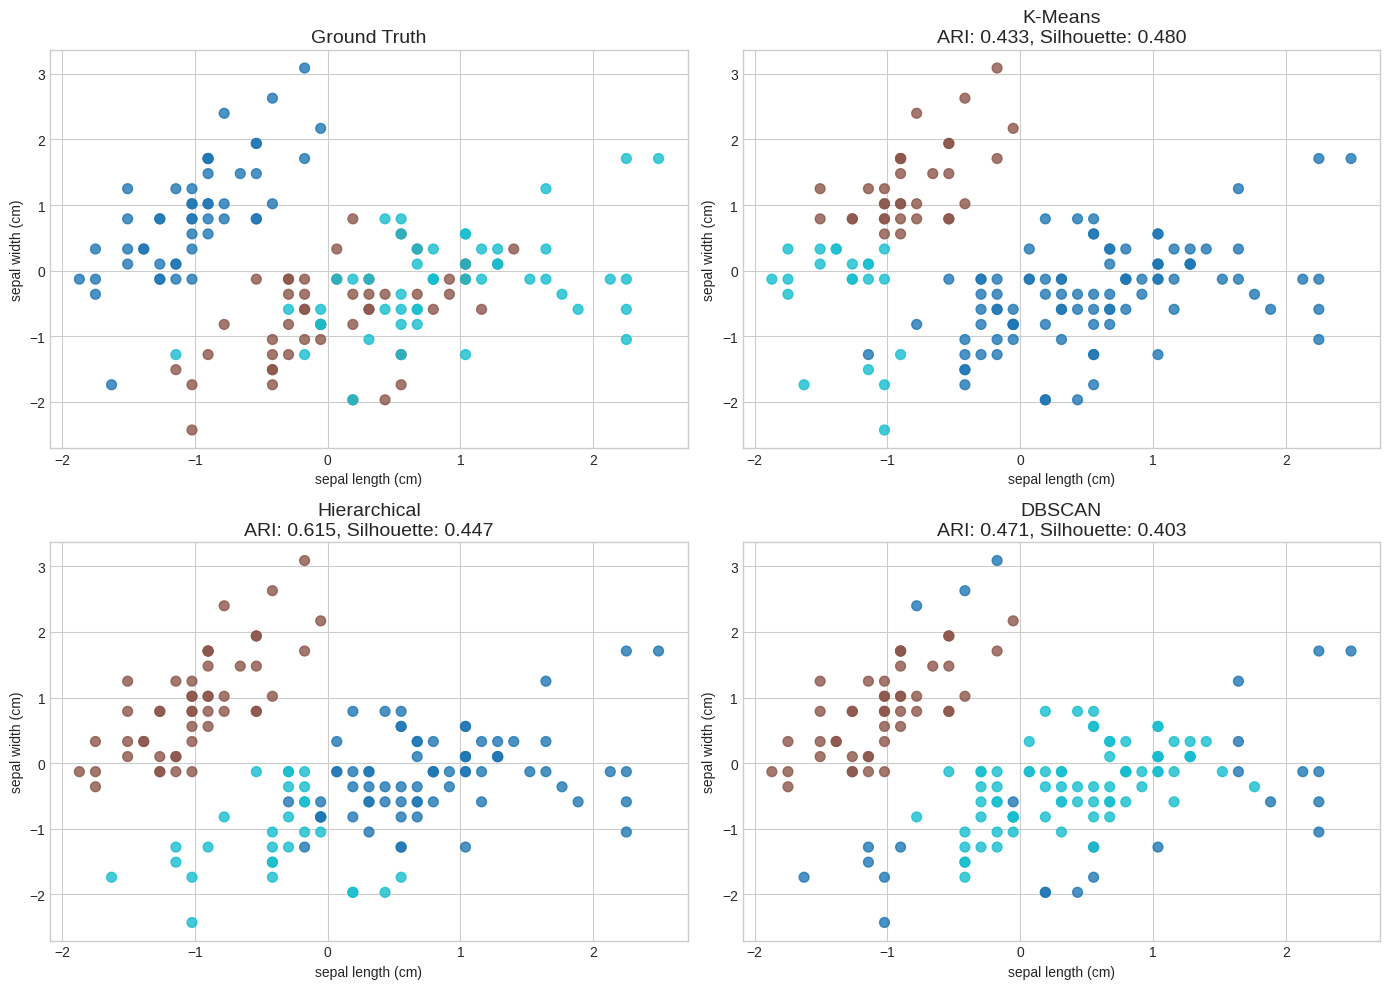

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot ground truth
axes[0].scatter(X_iris_scaled[:, 0], X_iris_scaled[:, 1], c=y_iris, cmap=cmap, s=50, alpha=0.8)
axes[0].set_title('Ground Truth', fontsize=14)
axes[0].set_xlabel(feature_names[0])
axes[0].set_ylabel(feature_names[1])

metrics_iris = []

for i, (algo_name, algo) in enumerate(algorithms.items(), 1):
    # Apply algorithm
    start_time = time.time()
    algo.fit(X_iris_scaled)
    runtime = time.time() - start_time

    # Get predictions
    labels = algo.labels_

    # Calculate metrics
    ari = adjusted_rand_score(y_iris, labels)

    # Calculate silhouette score
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1 and len(unique_labels) < len(X_iris):
        sil = silhouette_score(X_iris_scaled, labels)
    else:
        sil = float('nan')

    # Store metrics
    metrics_iris.append({
        'Algorithm': algo_name,
        'ARI': ari,
        'Silhouette': sil,
        'Runtime (s)': runtime,
        'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
    })

    # Plot results
    axes[i].scatter(X_iris_scaled[:, 0], X_iris_scaled[:, 1], c=labels, cmap=cmap, s=50, alpha=0.8)
    axes[i].set_title(f'{algo_name}\nARI: {ari:.3f}, Silhouette: {sil:.3f}', fontsize=14)
    axes[i].set_xlabel(feature_names[0])
    axes[i].set_ylabel(feature_names[1])

plt.tight_layout()
plt.show()

In [38]:
# Display metrics
metrics_iris_df = pd.DataFrame(metrics_iris)
display(metrics_iris_df)

Algorithm       ARI  Silhouette  Runtime (s)  n_clusters
0       K-Means  0.432805    0.479881     0.008147           3
1  Hierarchical  0.615323    0.446689     0.002154           3
2        DBSCAN  0.470627    0.402762     0.003819           2

In [40]:
# Apply PCA
pca = PCA(n_components=2)
X_iris_pca = pca.fit_transform(X_iris_scaled)

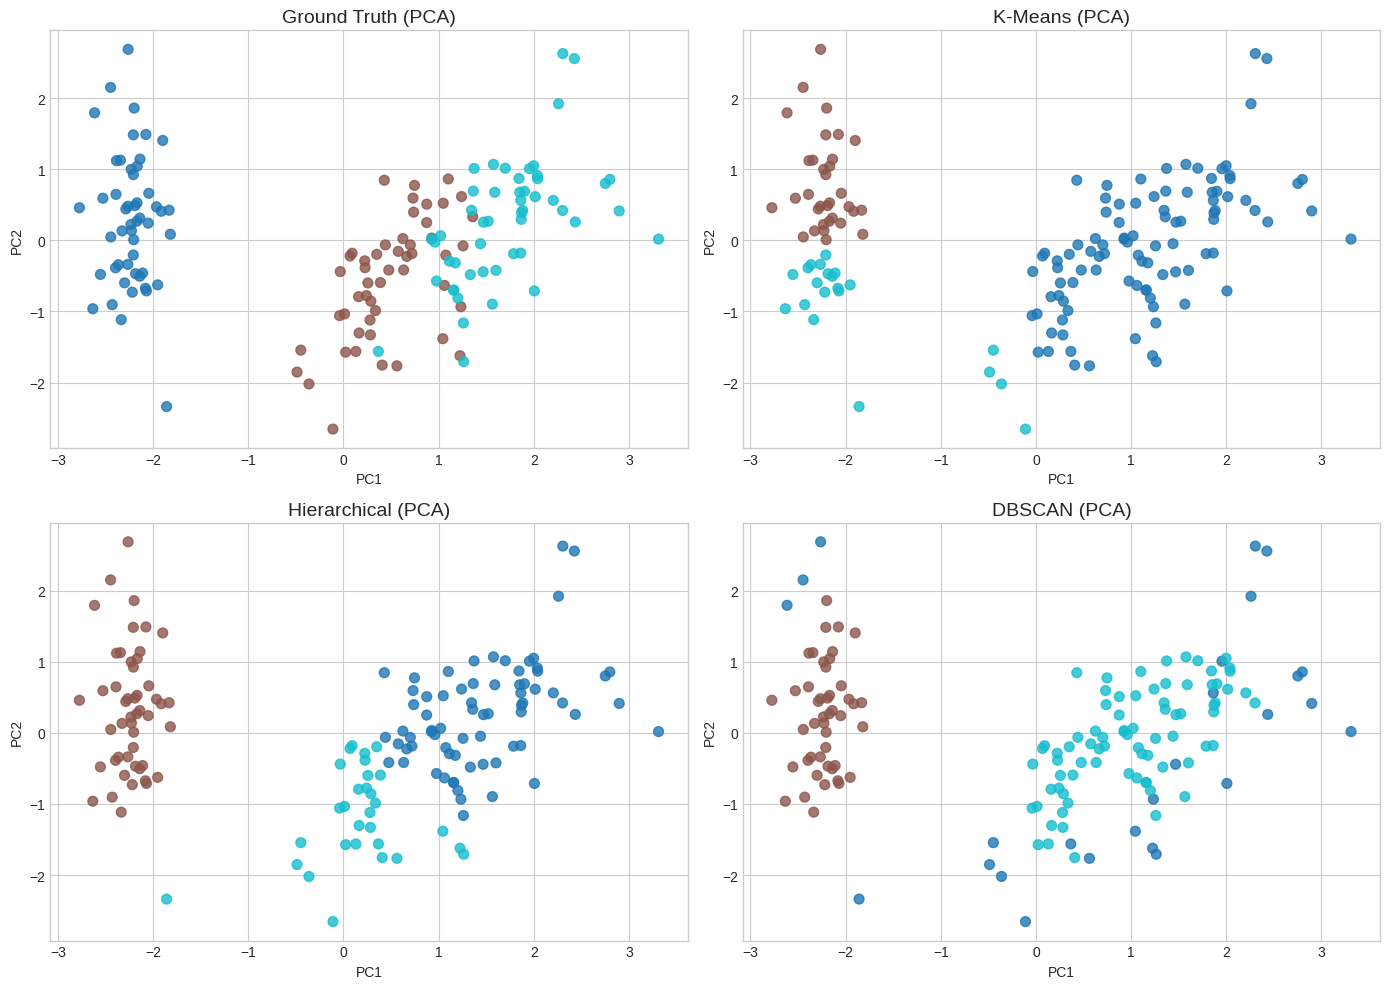

In [41]:
# Plot PCA results with different clustering results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Plot ground truth
axes[0].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_iris, cmap=cmap, s=50, alpha=0.8)
axes[0].set_title('Ground Truth (PCA)', fontsize=14)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

for i, (algo_name, algo) in enumerate(algorithms.items(), 1):
    # Plot results
    axes[i].scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=algo.labels_, cmap=cmap, s=50, alpha=0.8)
    axes[i].set_title(f'{algo_name} (PCA)', fontsize=14)
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')

plt.tight_layout()
plt.show()